In [7]:
import matplotlib.pyplot as plt
import torch
import cv2

In [28]:
sys.path.append('poseEstimation')
from demo import *

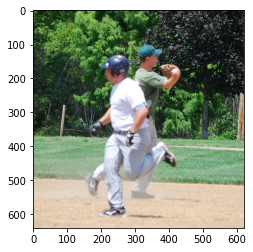

In [43]:
imagePath = "/home/vlados/diver_motion_patterns_recognition/test_data/000000000872.jpg"
frame_provider = ImageReader(imagePath)
image = cv2.imread(imagePath)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [44]:
def runDemo(net, img, height_size, cpu, track, smooth):
    net = net.eval()
    if not cpu:
        net = net.cuda()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 1
    orig_img = img.copy()
    heatmaps, pafs, scale, pad = infer_fast(net, img, height_size, stride, upsample_ratio, cpu)

    total_keypoints_num = 0
    all_keypoints_by_type = []
    for kpt_idx in range(num_keypoints):  # 19th for bg
        total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

    pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
    for kpt_id in range(all_keypoints.shape[0]):
        all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
        all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
    current_poses = []
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
        for kpt_id in range(num_keypoints):
            if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
        pose = Pose(pose_keypoints, pose_entries[n][18])
        current_poses.append(pose)

    if track:
        track_poses(previous_poses, current_poses, smooth=smooth)
        previous_poses = current_poses
    for pose in current_poses:
        pose.draw(img)
    img = cv2.addWeighted(orig_img, 0.6, img, 0.4, 0)
    for pose in current_poses:
        cv2.rectangle(img, (pose.bbox[0], pose.bbox[1]),
                        (pose.bbox[0] + pose.bbox[2], pose.bbox[1] + pose.bbox[3]), (0, 255, 0))
        if track:
            cv2.putText(img, 'id: {}'.format(pose.id), (pose.bbox[0], pose.bbox[1] - 16),
                        cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [31]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load("weights/checkpoint_iter_370000.pth", map_location='cpu')
load_state(net, checkpoint)
cpu = False
track = 1
height_size = 256
smooth = 1

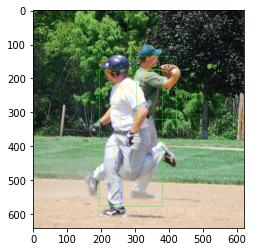

In [45]:
runDemo(net, image, height_size, cpu, track, smooth)